In [1]:
import sys, os
from pathlib import Path

project_root = "/Users/merlijnbroekers/Desktop/Drone_Interception"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH ok  — current cwd:", os.getcwd())
print("src/ exists?     ", os.path.exists(Path(project_root) / "src"))

PYTHONPATH ok  — current cwd: /Users/merlijnbroekers/Desktop/Drone_Interception/scripts/analysis
src/ exists?      True


In [2]:
import pickle
from pathlib import Path

from src.models.evaders.registry import build_evader
from src.models.pursuers.registry import build_pursuer  
from scripts.analysis.utils.metrics_utils import compute_simulation_metrics
from scripts.analysis.utils.notebook_helpers import AnalysisRunConfig
from scripts.analysis.utils.run_utils import list_evaders 
from scripts.analysis.utils.run_utils import Variant, run_sweep_variants
from scripts.analysis.utils.metrics_utils import aggregate_metrics_grouped


In [3]:
from src.utils.config import CONFIG

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# GLOBAL ANALYSIS CONSTANTS
# ─────────────────────────────────────────────────────────────────────────────

RUN_CFG = AnalysisRunConfig(
    n_trials=2,
    evader_csv_dir=f"{project_root}/evader_datasets/top_10_csv",
)

MODEL_ROOT = f"{project_root}/trained_models/abstraction_level_testing"

# Toggles for run/load behavior
RUN_TOGGLE = {
    "RECOMPUTE": False,
    "SAVE_RESULTS": False,
}

print(RUN_CFG)

AnalysisRunConfig(n_trials=2, evader_csv_dir='/Users/merlijnbroekers/Desktop/Drone_Interception/evader_datasets/top_10_csv', out_dir=None, results_csv=None, reuse_seed_per_evader=None)


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# CONTROL‑ABSTRACTION LEVEL REGISTRY
# ─────────────────────────────────────────────────────────────────────────────
LEVELS = {
    "motor": {
        "model": "motor",
        "controller": "rl",
        "action_dim": 4,
        "opt_feats": ["attitude_mat", "rates", "omega_norm"],
        "glob_prefix": "motor",  # to locate trained RL models
    },
    "acc_indi": {
        "model": "acc_indi",
        "controller": "rl",
        "action_dim": 3,
        # "opt_feats": ["attitude_mat", "rates", "T_force"],
        "opt_feats": [],
        "glob_prefix": "acc",
    },
    # "PointMass": {
    #     "model": "firstorder",
    #     "controller": "rl",
    #     "action_dim": 3,
    #     "opt_feats": [],
    #     "glob_prefix": "acc_1order",
    # },
    "ctbr": {
        "model": "ctbr",
        "controller": "rl",
        "action_dim": 4,
        "opt_feats": ["attitude_mat", "rates", "T_force"],
        "glob_prefix": "ctbr",
    },
    "acc_frpn": {
        "model": "acc_indi",
        "controller": "frpn",
        "action_dim": 3,
        "opt_feats": [],
        "glob_prefix": None,  # no RL folder
    },
}
print("Defined", len(LEVELS), "pursuer setups →", ", ".join(LEVELS))

Defined 4 pursuer setups → motor, acc_indi, ctbr, acc_frpn


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# HELPER FUNCTIONS  – EVADERS & POLICY DISCOVERY
# ─────────────────────────────────────────────────────────────────────────────
def discover_rl_policies():
    """Match trained RL policies on disk to LEVEL keys."""
    mapping = {}
    for p in Path(MODEL_ROOT).rglob("best_model.zip"):
        parent_dir = p.parent.parent.name  # ← now gets 'acc', 'ctbr', etc.
        for key, meta in LEVELS.items():
            if meta["controller"] == "rl" and meta["glob_prefix"] == parent_dir:
                mapping[key] = str(p)
    return mapping


print("Evaders discovered:", len(list_evaders(RUN_CFG.evader_csv_dir)))
print("RL policies discovered:", discover_rl_policies())

Evaders discovered: 10
RL policies discovered: {'ctbr': '/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/abstraction_level_testing/ctbr/models/best_model.zip', 'motor': '/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/abstraction_level_testing/motor/models/best_model.zip', 'acc_indi': '/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/abstraction_level_testing/acc/models/best_model.zip'}


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# PURSUER BUILDER FOR A GIVEN LEVEL
# ─────────────────────────────────────────────────────────────────────────────
def build_pursuer_for_level(level_key: str, policy_path: str | None, cfg: dict):
    meta = LEVELS[level_key]

    p_cfg = copy.deepcopy(cfg["PURSUER"])
    p_cfg["MODEL"] = meta["model"]  

    if meta["controller"] == "rl":
        if policy_path is None:
            raise ValueError(f"RL level '{level_key}' missing policy path")
        p_cfg["CONTROLLER"] = {"type": "rl", "policy_path": str(policy_path)}
    else:
        # FRPN baseline
        p_cfg["CONTROLLER"] = {"type": "frpn", "params": {"lambda_": 180, "pp_weight": 0.25}}

    return build_pursuer(p_cfg, cfg)

print("build_pursuer_for_level() ready ✓")

build_pursuer_for_level() ready ✓


In [8]:
def run_full_sweep(n_trials: int = RUN_CFG.n_trials):
    rl_policies = discover_rl_policies()
    variants = [Variant(key=k, meta={"policy_path": v}) for k, v in rl_policies.items()]
    evaders = list(list_evaders(RUN_CFG.evader_csv_dir))

    def build_cfg_fn(ev_cfg, level_key, meta):
        cfg = copy.deepcopy(CONFIG)
        metaL = LEVELS[level_key]
        cfg["OBSERVATIONS"]["ACTION_DIM"] = metaL["action_dim"]
        cfg["OBSERVATIONS"]["OPTIONAL_FEATURES"] = metaL["opt_feats"]
        cfg["EVADER"].update({k: v for k, v in ev_cfg.items() if k != "label"})
        return cfg

    def build_agents_fn(cfg, level_key, meta):
        evader = build_evader(cfg["EVADER"], cfg)
        pursuer = build_pursuer_for_level(level_key, meta["policy_path"], cfg)
        return pursuer, evader

    def extra_fields_fn(ev_cfg, level_key, meta, metrics, sim):
        return {"level": level_key}

    df = run_sweep_variants(
        evaders=evaders,
        variants=variants,
        n_trials=n_trials,
        build_cfg_fn=build_cfg_fn,
        build_agents_fn=build_agents_fn,
        compute_metrics_fn=compute_simulation_metrics,
        extra_fields_fn=extra_fields_fn,
        per_evader_seed_bank=False,
    )
    return df

In [9]:
trials_path = Path(project_root) / "analysis_out/trials/abstration.pkl"

In [10]:
# Compute or load trials based on toggles
if RUN_TOGGLE.get("RECOMPUTE", False):
    trials = run_full_sweep()
    if RUN_TOGGLE.get("SAVE_RESULTS", False):
        with open(trials_path, "wb") as f:
            pickle.dump(trials, f)
else:
    with open(trials_path, "rb") as f:
        trials = pickle.load(f)

In [11]:
aggregate_metrics_grouped(trials, group_cols=["level"])


Group: acc_indi
  first_interception_time   mean=2.489 std=1.255 med=2.410 Q1=1.413 Q3=3.345
  closest_distance          mean=0.044 std=0.023 med=0.042 Q1=0.029 Q3=0.048
  time_in_near_miss         mean=23.039 std=7.725 med=22.606 Q1=17.485 Q3=26.311
  total_interceptions       mean=64.200 std=29.911 med=54.500 Q1=41.250 Q3=83.250
  num_clusters              mean=3.600 std=1.625 med=3.500 Q1=2.000 Q3=5.000
  mean_distance             mean=0.587 std=0.114 med=0.578 Q1=0.527 Q3=0.637
  std_distance              mean=0.374 std=0.194 med=0.320 Q1=0.291 Q3=0.361
  interception_flag         mean=1.000 std=0.000 med=1.000 Q1=1.000 Q3=1.000
  ------------------------------------------------------------

Group: ctbr
  first_interception_time   mean=1.686 std=0.801 med=1.450 Q1=1.020 Q3=1.983
  closest_distance          mean=0.024 std=0.013 med=0.028 Q1=0.010 Q3=0.031
  time_in_near_miss         mean=38.730 std=6.906 med=37.968 Q1=35.429 Q3=41.819
  total_interceptions       mean=158.850 std=43

<Figure size 1200x500 with 0 Axes>

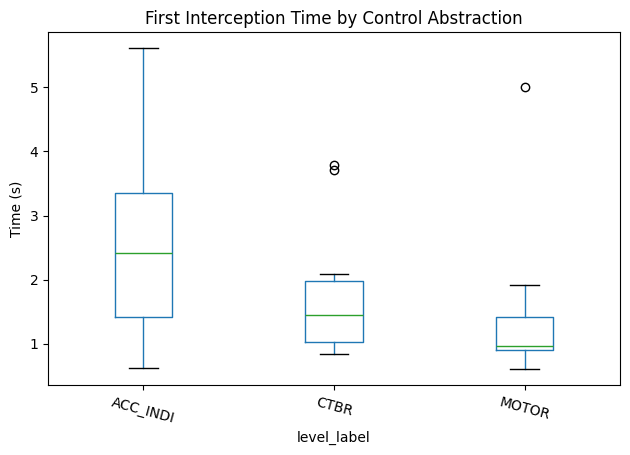

In [12]:
from scripts.analysis.utils.plot_utils import plot_first_interception_by_label

plot_first_interception_by_label(trials)

<Figure size 1200x500 with 0 Axes>

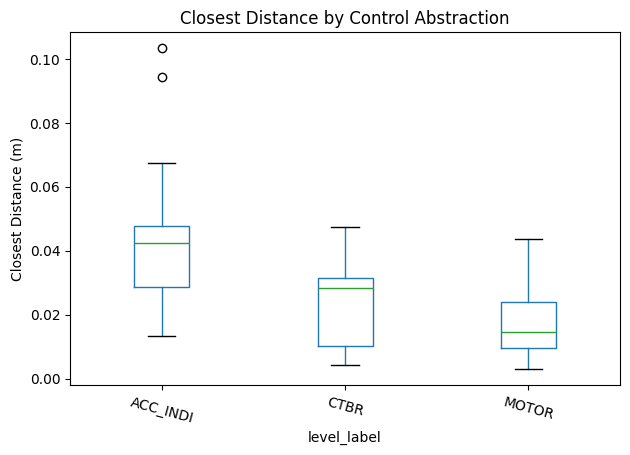

In [13]:

from scripts.analysis.utils.plot_utils import plot_closest_distance_by_label

plot_closest_distance_by_label(trials)

<Figure size 1200x500 with 0 Axes>

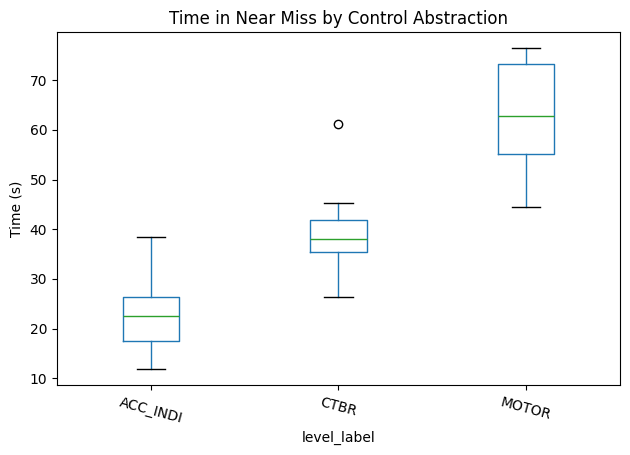

In [14]:

from scripts.analysis.utils.plot_utils import plot_near_miss_by_label

plot_near_miss_by_label(trials)